# Learning goals
After this week's lesson you should be able to:
- Read and write spatial data formats using GeoPandas
- Explore spatial data in a map
- Set and change map projections for GeoDataframes. 
- Create GeoDataFrames with CSVs.
- Perform a spatial and attribute join.

This week's lessons are adapted from:
- [Automating GIS Processes Lesson 2](https://autogis-site.readthedocs.io/en/latest/lessons/lesson-2/geopandas-an-introduction.html)
- Wenzheng Li's materials from CRP 5680 Spring 2022. 


# 0. What is geopandas? 

**Geopandas** is a python library that allows us to ingest, analyze, and map geospatial vector data. It combines what we have learned in the previous two classes: The tabular data analysis tools in **Pandas** with the geometry handling of shapely. Under the hood, it is using a python library called **fiona**, which handles all different kinds of spatial file formats, and **pyproj**, which manages our coordinate reference systems.

The main data structures in Geopandas are GeoDataFrames and GeoSeries, which are intended to mirror the Pandas DataFrame and Series structures. 

The key distinction in Geopandas is that we will always a column called `geometry` like so that contains the geometries related to each row: 
<figure class="image">
<img src="https://autogis-site.readthedocs.io/en/2019/_images/geodataframe.png" alt="drawing" width="500" style="display: block; margin: 0 auto"/>
 <figcaption><center>(From Automating GIS Processes)</figcaption>
</figure>

## 0.1 The three components of a GeoPandas GeoDataFrame
To create a GeoDataFrame, we need three things:

1. a pandas *DataFrame (df)*
2. a *CRS* (coordinate reference system presented by EPSG code, e.g., "epsg: 4326");
3. a shapely *geometry list* which defines the geometric object types of each observation, e.g., points, lines, or polygons.

We are familiar with 1. and 3. from the previous two classes and the Coordinate Reference System from your GIS knowledge. There is a different EPSG for each CRS. THe two most common that we will use are `EPSG:4326` (WGS84) and `EPSG:3857` (WGS84 / pseudo-Mercator, which is common projection used by Google and OSM). 



# 1. Reading to different spatial data file formats
Because of fiona's great under the hood functionality, Geopandas supports almost every vector spatial data format. For us, the two most common formats will be ESRI shapefiles and GeoJSONs.

Let's take a look at NYC subway data. 

Before we get started, let's orient where we are in our directory: 

In [1]:
# get your jupyter notebook path
import os
os.getcwd()

'/Users/yucheng/Documents/GitHub/4680_5680_intro_uds/Week2/Yucheng_s_Solutions'

Now let's read in the NYC subway stations dataset by doing the following: 
- Go to the NYC OpenData portal's page on the data for [Subway Stations](https://data.cityofnewyork.us/Transportation/Subway-Stations/arq3-7z49)
- Select **Export** in the upper-right hand corner of the page and and select **Shapefile**. 
- Save this file in the same folder as this notebook. 
- Keep it as a zipped file! (Geopandas can read both the zipped and unzipped version of the shapefile, but I like to keep it in zipped format because it's cleaner)

In [2]:
# We will need this to use geopandas
import geopandas as gpd
os.environ['USE_PYGEOS'] = '0'
# and remember that we're assigning a nickname to the package

# Now let's assign the variable name `stations` to the geodataframe
# These file names have spaces in them, which, as a reminder, 
# you should not do in your own work!
stations = gpd.read_file('Subway Stations.zip')


/var/folders/tl/kq7bhnbd4yxd5mt28m9t8g100000gn/T/ipykernel_41155/3571145978.py:2: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


# 2. Initial data exploration with Geopandads
Once we've read in the file, let's take a look at the data. I'm sure somewhere online is the data dictionary (which I couldn't find :/) but this table contains what we'd expect: 
- `objectid` which is the ID number for each geometry
- `name` the name of the station 
- `line` which are all the lines that stop at that station
- `geometry` which is the shapely geometry
- and other columns that we'll probably not need. 

In [3]:
# Same as you would do in Pandas
stations.head()

,line,name,notes,objectid,url,geometry
0,4-6-6 Express,Astor Pl,"4 nights, 6-all times, 6 Express-weekdays AM s...",1.0,http://web.mta.info/nyct/service/,POINT (-73.99107 40.73005)
1,4-6-6 Express,Canal St,"4 nights, 6-all times, 6 Express-weekdays AM s...",2.0,http://web.mta.info/nyct/service/,POINT (-74.00019 40.71880)
2,1-2,50th St,"1-all times, 2-nights",3.0,http://web.mta.info/nyct/service/,POINT (-73.98385 40.76173)
3,2-3-4,Bergen St,"4-nights, 3-all other times, 2-all times",4.0,http://web.mta.info/nyct/service/,POINT (-73.97500 40.68086)
4,3-4,Pennsylvania Ave,"4-nights, 3-all other times",5.0,http://web.mta.info/nyct/service/,POINT (-73.89489 40.66471)


But differently than a pandas dataframe, we can also do this with our data: 

<AxesSubplot: >

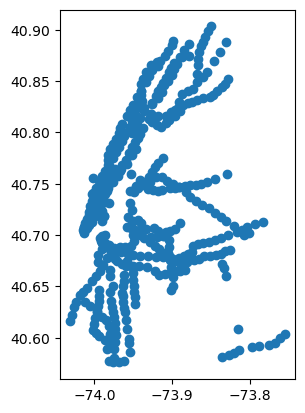

In [4]:
stations.plot()

We can also find the CRS for this dataset: 

In [5]:
stations.crs

<Geographic 2D CRS: GEOGCS["WGS84(DD)",DATUM["WGS84",SPHEROID["WGS84", ...>
Name: WGS84(DD)
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- undefined
Datum: WGS84
- Ellipsoid: WGS84
- Prime Meridian: Greenwich

# 3. Analyzing and manipulating data in geopandas

## 3.1 Changing projections 

Currently my data is in `EPSG:4326` but say I wanted to change my CRS to `EPSG:3857` as I know other datasets I'm working in are in 3857. 


I can use the `.to_crs()` function to do this: 

In [6]:
# Note here that this function requires as an input
# the name of the new coordinate system
stations.to_crs(epsg=3857)

,line,name,notes,objectid,url,geometry
0,4-6-6 Express,Astor Pl,"4 nights, 6-all times, 6 Express-weekdays AM s...",1.0,http://web.mta.info/nyct/service/,POINT (-8236648.235 4972605.859)
1,4-6-6 Express,Canal St,"4 nights, 6-all times, 6 Express-weekdays AM s...",2.0,http://web.mta.info/nyct/service/,POINT (-8237663.803 4970953.230)
2,1-2,50th St,"1-all times, 2-nights",3.0,http://web.mta.info/nyct/service/,POINT (-8235844.398 4977259.870)
3,2-3-4,Bergen St,"4-nights, 3-all other times, 2-all times",4.0,http://web.mta.info/nyct/service/,POINT (-8234859.237 4965382.255)
4,3-4,Pennsylvania Ave,"4-nights, 3-all other times",5.0,http://web.mta.info/nyct/service/,POINT (-8225941.072 4963012.202)
...,...,...,...,...,...,...
468,D-F-N-Q,Coney Island - Stillwell Av,"D,F,N,Q-all times",469.0,http://web.mta.info/nyct/service/,POINT (-8235553.520 4950189.238)
469,7-7 Express,34th St - Hudson Yards,"7-all times, 7 Express-rush hours AM westbound...",470.0,http://web.mta.info/nyct/service/,POINT (-8237886.898 4976336.703)
470,Q,72nd St,Q-all times,641.0,http://web.mta.info/nyct/service/,POINT (-8233007.174 4978299.664)
471,Q,86th St,Q-all times,642.0,http://web.mta.info/nyct/service/,POINT (-8232273.481 4979631.227)


Now let's check our dataset to make sure the CRS was changed: 

In [7]:
stations.crs

<Geographic 2D CRS: GEOGCS["WGS84(DD)",DATUM["WGS84",SPHEROID["WGS84", ...>
Name: WGS84(DD)
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- undefined
Datum: WGS84
- Ellipsoid: WGS84
- Prime Meridian: Greenwich

Hm, it wasn't changed! Why not? 

`stations.to_crs(epsg=3857)` only returns re-projected geometry, but if we don't re-assign our variable name `stations` to this reprojected version, the old version will not be updated. 

In [8]:
stations = stations.to_crs(epsg=3857)
stations.crs

<Derived Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

That worked! A good thing about using 3857 is that our units are in meters. This means that when we perform calculations on these geometries, the values we get are also going be in meters. 


## 3.2 Combining Pandas and Shapely functionalities

Note that you can use  the shapely functionalities we covered in class on Monday by selecting the geomeries from this GeoDataFrame

In [9]:
# Since the stations are points, they have no area
stations['geometry'].area

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
468    0.0
469    0.0
470    0.0
471    0.0
472    0.0
Length: 473, dtype: float64

In [10]:
stations['geometry'].buffer(10)

0      POLYGON ((-8236638.235 4972605.859, -8236638.2...
1      POLYGON ((-8237653.803 4970953.230, -8237653.8...
2      POLYGON ((-8235834.398 4977259.870, -8235834.4...
3      POLYGON ((-8234849.237 4965382.255, -8234849.2...
4      POLYGON ((-8225931.072 4963012.202, -8225931.1...
                             ...                        
468    POLYGON ((-8235543.520 4950189.238, -8235543.5...
469    POLYGON ((-8237876.898 4976336.703, -8237876.9...
470    POLYGON ((-8232997.174 4978299.664, -8232997.2...
471    POLYGON ((-8232263.481 4979631.227, -8232263.5...
472    POLYGON ((-8231739.735 4980568.521, -8231739.7...
Length: 473, dtype: geometry

In [11]:
# This returns the x coordinate of each row's point
stations['geometry'].x

0     -8.236648e+06
1     -8.237664e+06
2     -8.235844e+06
3     -8.234859e+06
4     -8.225941e+06
           ...     
468   -8.235554e+06
469   -8.237887e+06
470   -8.233007e+06
471   -8.232273e+06
472   -8.231750e+06
Length: 473, dtype: float64

You can also use the Pandas functionalities: 

In [12]:
stations.loc[1:10,'geometry']

1     POINT (-8237663.803 4970953.230)
2     POINT (-8235844.398 4977259.870)
3     POINT (-8234859.237 4965382.255)
4     POINT (-8225941.072 4963012.202)
5     POINT (-8226607.218 4995344.928)
6     POINT (-8232974.326 4982971.838)
7     POINT (-8231058.773 4965243.812)
8     POINT (-8226375.493 4975495.148)
9     POINT (-8229740.659 4975824.382)
10    POINT (-8236240.740 4970880.241)
Name: geometry, dtype: geometry

In [13]:
# Note that we can take the head of any column 
# or subset of columns 

stations['name'].head()

0            Astor Pl
1            Canal St
2             50th St
3           Bergen St
4    Pennsylvania Ave
Name: name, dtype: object

## 3.3 Mapping
Let's talk about mapping in a bit more detail here.

You can also read the [GeoPandas user guide](https://geopandas.org/en/stable/docs/user_guide/mapping.html) for more on mapping. 

Beyond the basic map we just made above, we use the following to enhance our map a bit: 

We can specify which column will determine the color schema of the plot. If the column is a numeric data type (`int` or `float`) `plot()` will try to create a **choropleth** map, if the column is a `str` or `obj`, it will try to create a **categorical** map.

In [14]:
# The column 'line' is an object type here
stations['line'].dtype

dtype('O')

<AxesSubplot: >

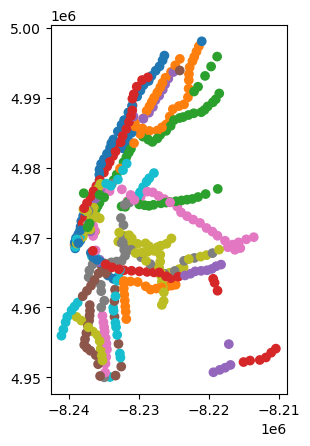

In [15]:
stations.plot(column='line')

# This plot is not very informative
# since there are many different combinations of lines that pass through 
# each station
# The map does not exactly line up with subway lines

We can also specifcy the size of our plot using the `figsize=` optional input. 

<AxesSubplot: >

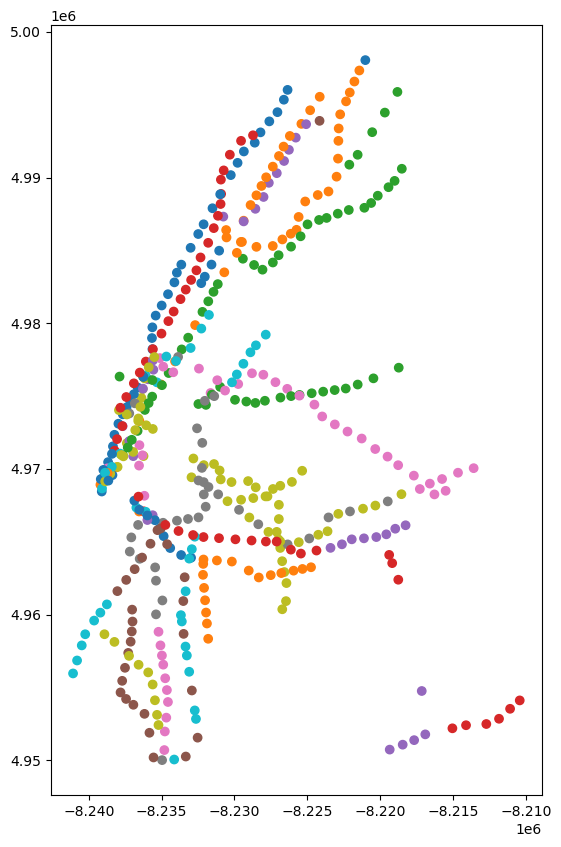

In [16]:
# Here, we're using the `figsize` argument to make the plot bigger
# figsize takes a tuple of (width, height) in inches
stations.plot(column='line',
            figsize=(10,10))

Because the dimensions of the plot are constrained by the CRS we use, `figsize` is going to find the largest plot it can create given these dimension constraints.

<AxesSubplot: >

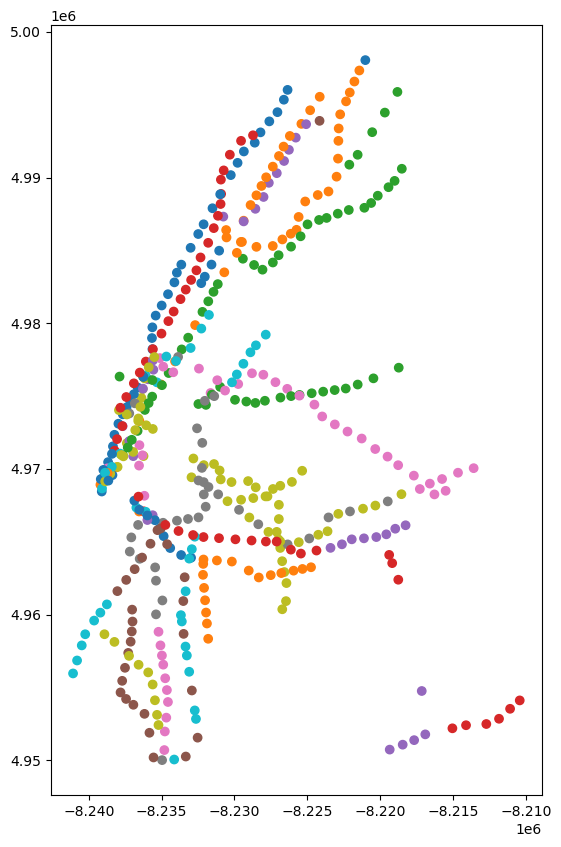

In [17]:
# This produces the same size plot as above
stations.plot(column='line',
            figsize=(20,10))

You can also add a legend to this plot

<AxesSubplot: >

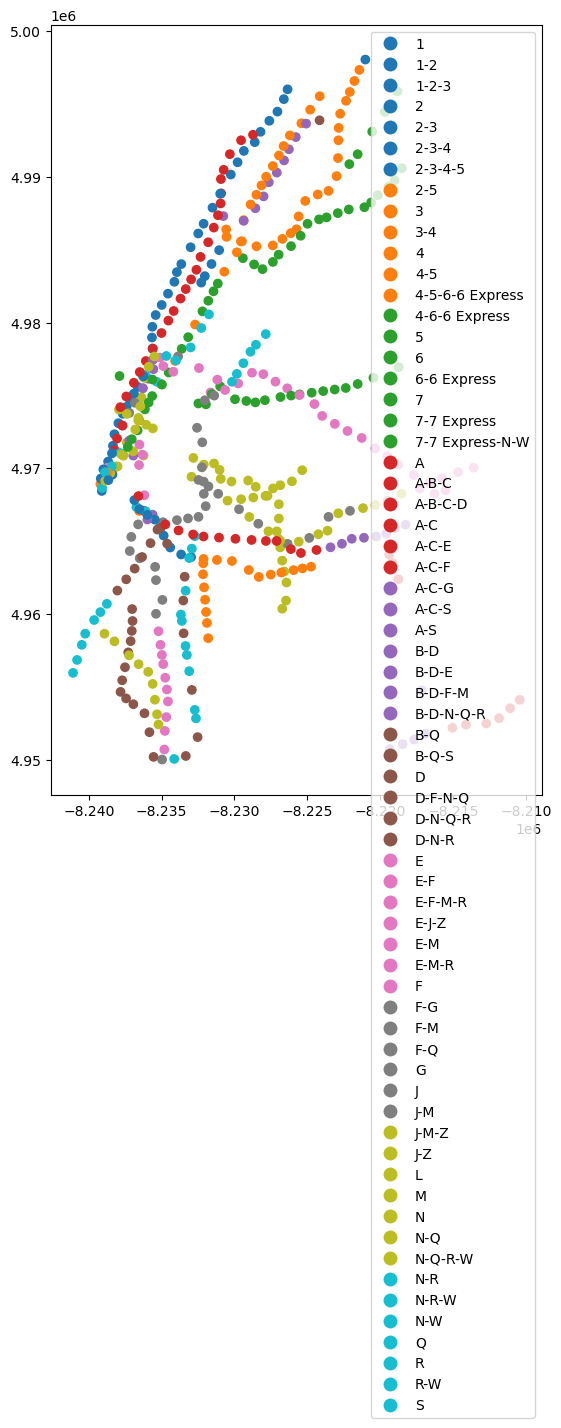

In [18]:
# This produces the same size plot as above
stations.plot(column='line',
            figsize=(20,10),
            legend=True)

# This legend is not very informative 
# given the issue mentioned above 
# that there are many different combinations of lines that pass through
# each station

# 4. Working with multiple geospatial datasets. 

Most often, we are working with multiple datasets in order to analyze their relationship to each other.


For this example, let's take a look at public housing accessibility from a transit perspective. 

First, download the NYCHA public housing data from [here](https://data.cityofnewyork.us/Housing-Development/Map-of-NYCHA-Developments/i9rv-hdr5) and save it down in the same folder that contains this notebook. 

In [19]:
# A bad file name again! Also, why do they call it a "Map"?
public_housing = gpd.read_file('Map of NYCHA Developments.zip')

# We are going to filter the data to exclude MultiPolygon objects for this exercise
public_housing = public_housing[public_housing['geometry'].type!='MultiPolygon']

# oops, there's a typo in the column name where "development" is spelled
# "developmen". 
# Let's fix that.
public_housing = public_housing.rename(columns={'developmen':'development'})


In [20]:
public_housing.head()

,borough,development,tds_num,geometry
0,BRONX,1010 EAST 178TH STREET,180,"POLYGON ((-73.88092 40.84050, -73.88068 40.840..."
1,MANHATTAN,HOLMES TOWERS,159,"POLYGON ((-73.94445 40.78071, -73.94456 40.780..."
2,BROOKLYN,104-14 TAPSCOTT STREET,242,"POLYGON ((-73.92039 40.66498, -73.92074 40.664..."
3,BRONX,1162-1176 WASHINGTON AVENUE,233,"POLYGON ((-73.90694 40.83009, -73.90705 40.829..."
4,MANHATTAN,131 SAINT NICHOLAS AVENUE,154,"POLYGON ((-73.95286 40.80376, -73.95317 40.803..."


In [21]:
public_housing.crs

<Geographic 2D CRS: GEOGCS["WGS84(DD)",DATUM["WGS84",SPHEROID["WGS84", ...>
Name: WGS84(DD)
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- undefined
Datum: WGS84
- Ellipsoid: WGS84
- Prime Meridian: Greenwich

<AxesSubplot: >

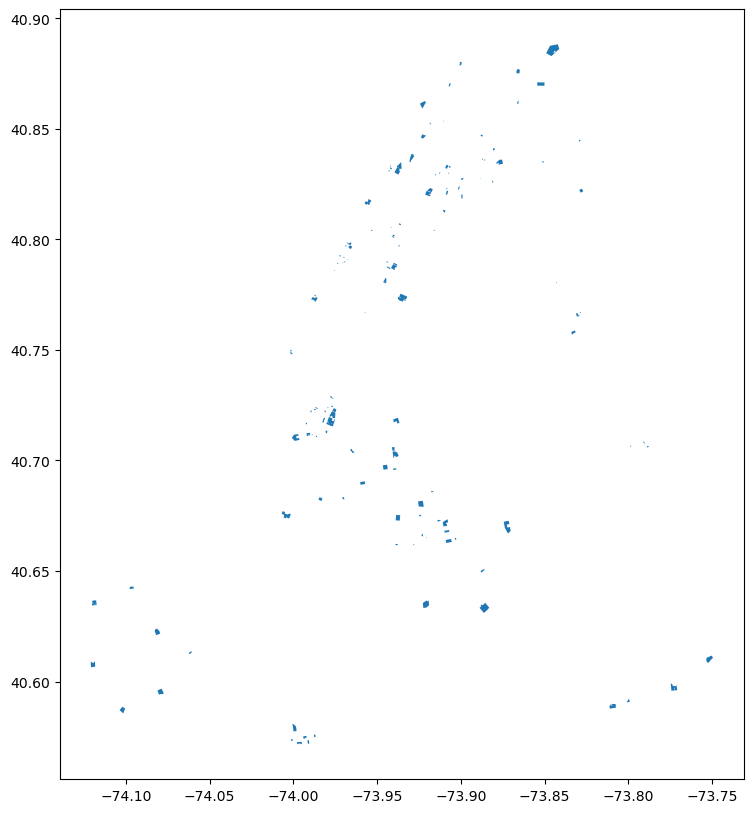

In [22]:
# This look very faint, because we're working with building footprints 
# at the scale of the entire city
public_housing.plot(figsize=(10,10))

Let's first change our CRS to 3857. 

In [23]:
public_housing = public_housing.to_crs(epsg=3857)

Now, let's say we want calculate **how many subway stations are within a 10 minute walk of each housing unit**. 

We are going to do this by: 
- Providing an estimate of the distance a typical person can walk in 10 minutes
- Creating a new geometry that is buffered around each building by that distance.


A quick google search tells me 10 minutes is about 800 meters based on average walking speeds. 

## 4.1 Making a new GeoDataFrame
Let's make a new dataset that buffers each building with a 800 meter distance but still has the original tabular data of our public housing dataset. Recall that a GeoDataFrame takes a dataframe, a CRS, and a set of geometries

In [24]:
# First, let's make our geometries
buffer_geom = public_housing['geometry'].buffer(800)

# Second, we already know the CRS
# This the same as the CRS of public housing data 
buffer_crs = public_housing.crs 

# Third, let's grab the data we want
buffer_data = public_housing[['borough', 'development', 'tds_num']]  

# Now, let's put it all together using the GeoDataFrame constructor
public_housing_buffer = gpd.GeoDataFrame(buffer_data, crs=buffer_crs, geometry=buffer_geom)

<AxesSubplot: >

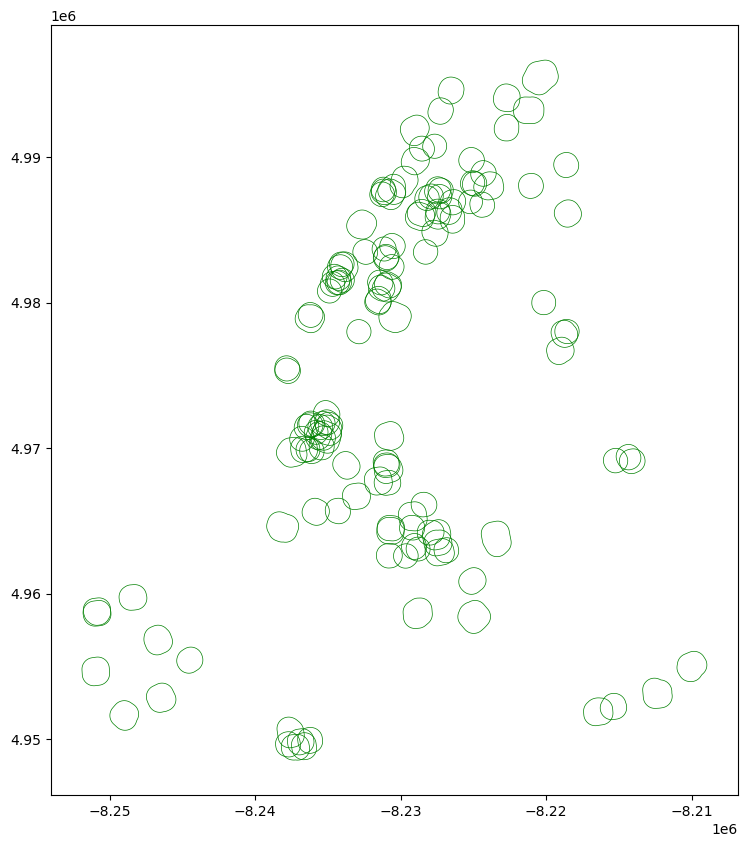

In [25]:
# Note that I've started new lines for each argument 
# to make it easier to read
public_housing_buffer.plot(figsize=(10,10),
                            facecolor="none", 
                            edgecolor="green", 
                            lw=.5)

Whoa, what happened here?? Beyond setting the figure size, I'm including other optional inputs that allows me to style these more clearly. 
- `facecolor` is the fill color, which I want to set to "none" to make the polygons transparent
- `edgecolor` is the edge color, and `plot()` [recognizes certain named colors](https://matplotlib.org/stable/gallery/color/named_colors.html). 
- `lw` allows me to set the line weight. 

## 4.1.1 (Detour) Making a new GeoDataFrame from a CSV  
Let's say we have a CSV with a latitude and longitude column. We can easily turn this into a GeoDataFrame by transforming these lat/lng shapely `Points`. 

As an example: 
- download the CSV of [NYC Firehouses](https://data.cityofnewyork.us/Public-Safety/FDNY-Firehouse-Listing/hc8x-tcnd). (It's under **Export**.)
- Make sure this CSV is in the same folder as this notebook. 

In [26]:
import pandas as pd
firehouses_csv = pd.read_csv('FDNY_Firehouse_Listing.csv')
firehouses_csv.head()

,FacilityName,FacilityAddress,Borough,Postcode,Latitude,Longitude,Community Board,Community Council,Census Tract,BIN,BBL,NTA
0,Engine 4/Ladder 15,42 South Street,Manhattan,10005,40.703694,-74.007717,101,1,7,1000867,1000350001,Battery Park City-Lower Manhattan
1,Engine 6,49 Beekman Street,Manhattan,10038,40.709971,-74.005395,101,1,1501,1001287,1000930030,Battery Park City-Lower Manhattan
2,Manhattan Borough Command/Battalion 1/Engine 7...,100 Duane Street,Manhattan,10007,40.715339,-74.006300,101,1,33,1001647,1001500025,SoHo-TriBeCa-Civic Center-Little Italy
3,Ladder 8,14 N. Moore Street,Manhattan,10013,40.719574,-74.006620,101,1,33,1002150,1001890035,SoHo-TriBeCa-Civic Center-Little Italy
4,Engine 9/Ladder 6,75 Canal Street,Manhattan,10002,40.715408,-73.992834,103,1,16,1003898,1003000030,Chinatown


In order to create a GeoDataFrame, we need to Geopandas all three components (data/DF, CRS, and geometry) of the GeoDataFrame. We will use the `points_from_xy()` function in GeoPandas. This is basically using shapely `Points` under the hood. 

In [27]:
# I know this is 4326 but it also says on the Firehouses listing page:
# "Latitude coordinate for Global Coordinate System, WGS 1984, decimal degrees (EPSG 4326)"
firehouses = gpd.GeoDataFrame(firehouses_csv, 
                            geometry=gpd.points_from_xy(firehouses_csv['Longitude'], firehouses_csv['Latitude']),
                            crs='EPSG:4326')

In [28]:
# Voila
firehouses.head()

,FacilityName,FacilityAddress,Borough,Postcode,Latitude,Longitude,Community Board,Community Council,Census Tract,BIN,BBL,NTA,geometry
0,Engine 4/Ladder 15,42 South Street,Manhattan,10005,40.703694,-74.007717,101,1,7,1000867,1000350001,Battery Park City-Lower Manhattan,POINT (-74.00772 40.70369)
1,Engine 6,49 Beekman Street,Manhattan,10038,40.709971,-74.005395,101,1,1501,1001287,1000930030,Battery Park City-Lower Manhattan,POINT (-74.00539 40.70997)
2,Manhattan Borough Command/Battalion 1/Engine 7...,100 Duane Street,Manhattan,10007,40.715339,-74.006300,101,1,33,1001647,1001500025,SoHo-TriBeCa-Civic Center-Little Italy,POINT (-74.00630 40.71534)
3,Ladder 8,14 N. Moore Street,Manhattan,10013,40.719574,-74.006620,101,1,33,1002150,1001890035,SoHo-TriBeCa-Civic Center-Little Italy,POINT (-74.00662 40.71957)
4,Engine 9/Ladder 6,75 Canal Street,Manhattan,10002,40.715408,-73.992834,103,1,16,1003898,1003000030,Chinatown,POINT (-73.99283 40.71541)


<AxesSubplot: >

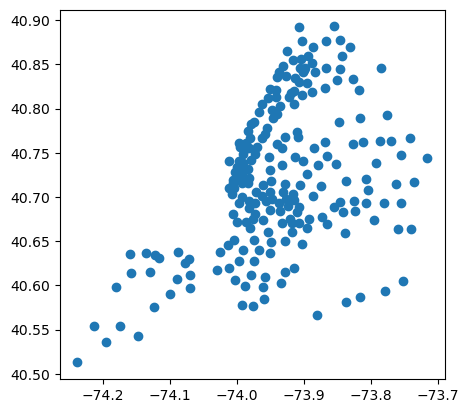

In [29]:
firehouses.plot()

Going back to our public housing buffer data, let's see what it looks like.

## 4.2 Creating a spatial join 

Now, let's count how many subway stations are in each buffer to get a sense of transit accessibility by using a spatial join between our new `public_housing_buffer` dataset and our `subway_stops` dataset. 

We are going to use  `gpd.sjoin(left_geoDF,right_geoDF)`. This function optionally takes as an input `how` to specify what type of spatial join. 

There are couple of different types of spatial joins: 
- `Left outer join`: In a LEFT OUTER JOIN (how='left'), we keep all rows from the left and duplicate them if necessary to represent multiple hits between the two dataframes. We retain attributes of the right if they intersect and lose right rows that don’t intersect. A left outer join implies that we are interested in retaining the geometries of the left.
- `Right outer join`: In a RIGHT OUTER JOIN (how='right'), we keep all rows from the right and duplicate them if necessary to represent multiple hits between the two dataframes. We retain attributes of the left if they intersect and lose left rows that don’t intersect. A right outer join implies that we are interested in retaining the geometries of the right.
- `Inner join` (this is the default setting): In an INNER JOIN (how='inner'), we keep rows from the right and left only where their binary predicate is True. We duplicate them if necessary to represent multiple hits between the two dataframes. We retain attributes of the right and left only if they intersect and lose all rows that do not. An inner join implies that we are interested in retaining the geometries of the left.

In this case, we want to join `public_housing_buffer` and `stations` and a **left outer join** because we want to keep the hits between our public housing buffer and all the subway stations. 

In [30]:
# Before we assign this to a new variable, 
# let's check to see what the join looks like
gpd.sjoin(public_housing_buffer,stations,how='left')

,borough,development,tds_num,geometry,index_right,line,name,notes,objectid,url
0,BRONX,1010 EAST 178TH STREET,180,"POLYGON ((-8225180.045 4988937.223, -8225178.0...",271.0,2-5,West Farms Sq - E Tremont Av,"2-all times, 5-all times exc nights, skips rus...",272.0,http://web.mta.info/nyct/service/
0,BRONX,1010 EAST 178TH STREET,180,"POLYGON ((-8225180.045 4988937.223, -8225178.0...",284.0,2-5,E 180th St,"2,5-all times",285.0,http://web.mta.info/nyct/service/
1,MANHATTAN,HOLMES TOWERS,159,"POLYGON ((-8231070.035 4980749.205, -8231003.4...",471.0,Q,86th St,Q-all times,642.0,http://web.mta.info/nyct/service/
1,MANHATTAN,HOLMES TOWERS,159,"POLYGON ((-8231070.035 4980749.205, -8231003.4...",472.0,Q,96th St,Q-all times,643.0,http://web.mta.info/nyct/service/
2,BROOKLYN,104-14 TAPSCOTT STREET,242,"POLYGON ((-8227994.209 4963201.594, -8227983.2...",220.0,3-4,Saratoga Ave,"4-nights, 3-all other times",221.0,http://web.mta.info/nyct/service/
...,...,...,...,...,...,...,...,...,...,...
276,BROOKLYN,WYCKOFF GARDENS,163,"POLYGON ((-8235337.995 4966372.022, -8235270.0...",35.0,D-N-R,Union St,"D,N-nights, R-all other times",36.0,http://web.mta.info/nyct/service/
276,BROOKLYN,WYCKOFF GARDENS,163,"POLYGON ((-8235337.995 4966372.022, -8235270.0...",366.0,A-C-G,Hoyt - Schermerhorn Sts,"A,G-all times, C-all times exc nights",367.0,http://web.mta.info/nyct/service/
276,BROOKLYN,WYCKOFF GARDENS,163,"POLYGON ((-8235337.995 4966372.022, -8235270.0...",121.0,D-N-Q-R,Atlantic Av - Barclay's Center,"D,N-all times, R-all times exc nights",122.0,http://web.mta.info/nyct/service/
276,BROOKLYN,WYCKOFF GARDENS,163,"POLYGON ((-8235337.995 4966372.022, -8235270.0...",115.0,2-3-4-5,Atlantic Av - Barclay's Center,"2,4-all times, 3-all times exc nights, 5-weekdays",116.0,http://web.mta.info/nyct/service/


As we can, see there are duplicate rows of the buffers where each buffered geometry has intersected with multiple stations.

Great, since that looked like it worked, let's assign it to a new variable name: 


In [31]:
buffers_w_stations = gpd.sjoin(public_housing_buffer,stations,how='left')

Lastly, we are going use a common pandas operation I'm going to call **groupby-and-summarize**. Here, we aggregate our tabular data by a column containing a category (here, we are aggregating by `development` and perform some kind of summary function, typically something like a count, mean, min, or max. 

It's constructed like so: 
- `df.groupby('col_name').sum()` or
- `df.groupby('col_name').count()` or
- `df.groupby('col_name').min()`

Note, however, that the sum/count/min will be applied to all numeric columns

In [32]:
buffers_w_stations.head(10)

,borough,development,tds_num,geometry,index_right,line,name,notes,objectid,url
0,BRONX,1010 EAST 178TH STREET,180,"POLYGON ((-8225180.045 4988937.223, -8225178.0...",271.0,2-5,West Farms Sq - E Tremont Av,"2-all times, 5-all times exc nights, skips rus...",272.0,http://web.mta.info/nyct/service/
0,BRONX,1010 EAST 178TH STREET,180,"POLYGON ((-8225180.045 4988937.223, -8225178.0...",284.0,2-5,E 180th St,"2,5-all times",285.0,http://web.mta.info/nyct/service/
1,MANHATTAN,HOLMES TOWERS,159,"POLYGON ((-8231070.035 4980749.205, -8231003.4...",471.0,Q,86th St,Q-all times,642.0,http://web.mta.info/nyct/service/
1,MANHATTAN,HOLMES TOWERS,159,"POLYGON ((-8231070.035 4980749.205, -8231003.4...",472.0,Q,96th St,Q-all times,643.0,http://web.mta.info/nyct/service/
2,BROOKLYN,104-14 TAPSCOTT STREET,242,"POLYGON ((-8227994.209 4963201.594, -8227983.2...",220.0,3-4,Saratoga Ave,"4-nights, 3-all other times",221.0,http://web.mta.info/nyct/service/
2,BROOKLYN,104-14 TAPSCOTT STREET,242,"POLYGON ((-8227994.209 4963201.594, -8227983.2...",221.0,3-4,Sutter Ave - Rutland Road,"4-nights, 3-all other times",222.0,http://web.mta.info/nyct/service/
3,BRONX,1162-1176 WASHINGTON AVENUE,233,"POLYGON ((-8226967.873 4988047.243, -8226897.5...",NaN,NaN,NaN,NaN,NaN,NaN
4,MANHATTAN,131 SAINT NICHOLAS AVENUE,154,"POLYGON ((-8231595.644 4983474.449, -8231595.9...",6.0,A-B-C,Cathedral Pkwy (110th St),"A-nights, B-weekdays and evenings, C-all times...",7.0,http://web.mta.info/nyct/service/
4,MANHATTAN,131 SAINT NICHOLAS AVENUE,154,"POLYGON ((-8231595.644 4983474.449, -8231595.9...",159.0,2-3,Central Park North (110th St),"2,3-all times",160.0,http://web.mta.info/nyct/service/
4,MANHATTAN,131 SAINT NICHOLAS AVENUE,154,"POLYGON ((-8231595.644 4983474.449, -8231595.9...",169.0,2-3,116th St,"2,3-all times",170.0,http://web.mta.info/nyct/service/


In [33]:
# Here we are counting all the instances of each column value per development. 
buffers_w_stations.groupby('development').count()

,borough,tds_num,geometry,index_right,line,name,notes,objectid,url
development,,,,,,,,,
1010 EAST 178TH STREET,2,2,2,2,2,2,2,2,2
104-14 TAPSCOTT STREET,2,2,2,2,2,2,2,2,2
1162-1176 WASHINGTON AVENUE,1,1,1,0,0,0,0,0,0
131 SAINT NICHOLAS AVENUE,4,4,4,4,4,4,4,4,4
1471 WATSON AVENUE,2,2,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...
WILSON,1,1,1,0,0,0,0,0,0
WSUR (SITE A) 120 WEST 94TH STREET,2,2,2,2,2,2,2,2,2
WSUR (SITE B) 74 WEST 92ND STREET,4,4,4,4,4,4,4,4,4


## Q.1 In-Class Execise #1 (2pts)
Q: In our the code `buffers_w_stations.groupby('development').count()` why do some rows have the same count all the way across and why do some rows have different counts in the row? ? 

A: Since we are performing a left outer join, we retains the records from the left. If a entry in the left does not contain a station, the right values will be NAN, which results in a 0 count rather than a positive count at left.

Here, the column we are interested in is `objectid` which is now displaying a count of the different station IDs within each development's buffer. 

In [34]:
station_counts = buffers_w_stations.groupby('development').count()['objectid']
station_counts

development
1010 EAST 178TH STREET                2
104-14 TAPSCOTT STREET                2
1162-1176 WASHINGTON AVENUE           0
131 SAINT NICHOLAS AVENUE             4
1471 WATSON AVENUE                    2
                                     ..
WILSON                                0
WSUR (SITE A) 120 WEST 94TH STREET    2
WSUR (SITE B) 74 WEST 92ND STREET     4
WSUR (SITE C) 589 AMSTERDAM AVENUE    3
WYCKOFF GARDENS                       5
Name: objectid, Length: 142, dtype: int64

## 4.3 Attribute joins 
Now, let's join this back to our `public_housing_buffers` GeoDataFrame so we can map it. 

In an attribute join, a `GeoSeries` or `GeoDataFrame` is combined with a regular `pandas.Series` or `pandas.DataFrame` based on a common variable. This is analogous to normal merging or joining in pandas.

This is what a merge looks like visually

</figure>
<img src="https://miro.medium.com/max/1400/1*ZCpo3gXuXI4KFhKivEt2ZA.png " alt="drawing" width="700" style="display: block; margin: 0 auto"/>
</figure>


In [35]:
# .merge() takes as an argument the dataframe you want to merge with
# and the left and right columns you want to merge on
# Here, we're merging on the index of the station_counts pandas.Series
# and the development column of the public_housing_buffer geodataframe
public_housing_buffer.merge(station_counts, 
                            left_on='development', 
                            right_index=True)

# You will typically be merging on a column, not an index
# Here station_counts has the development column as its index   

,borough,development,tds_num,geometry,objectid
0,BRONX,1010 EAST 178TH STREET,180,"POLYGON ((-8225180.045 4988937.223, -8225178.0...",2
1,MANHATTAN,HOLMES TOWERS,159,"POLYGON ((-8231070.035 4980749.205, -8231003.4...",2
2,BROOKLYN,104-14 TAPSCOTT STREET,242,"POLYGON ((-8227994.209 4963201.594, -8227983.2...",2
3,BRONX,1162-1176 WASHINGTON AVENUE,233,"POLYGON ((-8226967.873 4988047.243, -8226897.5...",0
4,MANHATTAN,131 SAINT NICHOLAS AVENUE,154,"POLYGON ((-8231595.644 4983474.449, -8231595.9...",4
...,...,...,...,...,...
269,MANHATTAN,WILSON,112,"POLYGON ((-8229983.018 4980947.249, -8230006.4...",0
273,MANHATTAN,WSUR (SITE A) 120 WEST 94TH STREET,151,"POLYGON ((-8233846.752 4982388.142, -8233780.2...",2
274,MANHATTAN,WSUR (SITE B) 74 WEST 92ND STREET,173,"POLYGON ((-8233791.860 4982115.411, -8233725.2...",4
275,MANHATTAN,WSUR (SITE C) 589 AMSTERDAM AVENUE,174,"POLYGON ((-8234268.566 4982019.499, -8234202.0...",3


That worked! Let's update our `public_housing_buffer` variable name to point to our updated geodataframe with this new column

In [36]:
public_housing_buffer = public_housing_buffer.merge(station_counts, 
                            left_on='development', 
                            right_index=True)

The last thing I want to change is the column name from `objectid`, which it is not, to somethign more descriptive. 

In [37]:
public_housing_buffer = public_housing_buffer.rename(columns={'objectid':'station_count'})

## 4.4 Writing to a file
Now let's write this buffer data we've created to a file. The default is writing to a shapefile. 

In [38]:
# this will write to a folder containing a .shp, .shx, .dbf, and .prj file
public_housing_buffer.to_file('public_housing_buffer')


/var/folders/tl/kq7bhnbd4yxd5mt28m9t8g100000gn/T/ipykernel_41155/3169208411.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  public_housing_buffer.to_file('public_housing_buffer')


In [39]:
# This will write to a single .geojson file
# You need to specify the driver
public_housing_buffer.to_file('public_housing_buffer_geojson',driver='GeoJSON')

## 4.5 Making a choropleth map

Now let's make a choropleth map.

<AxesSubplot: >

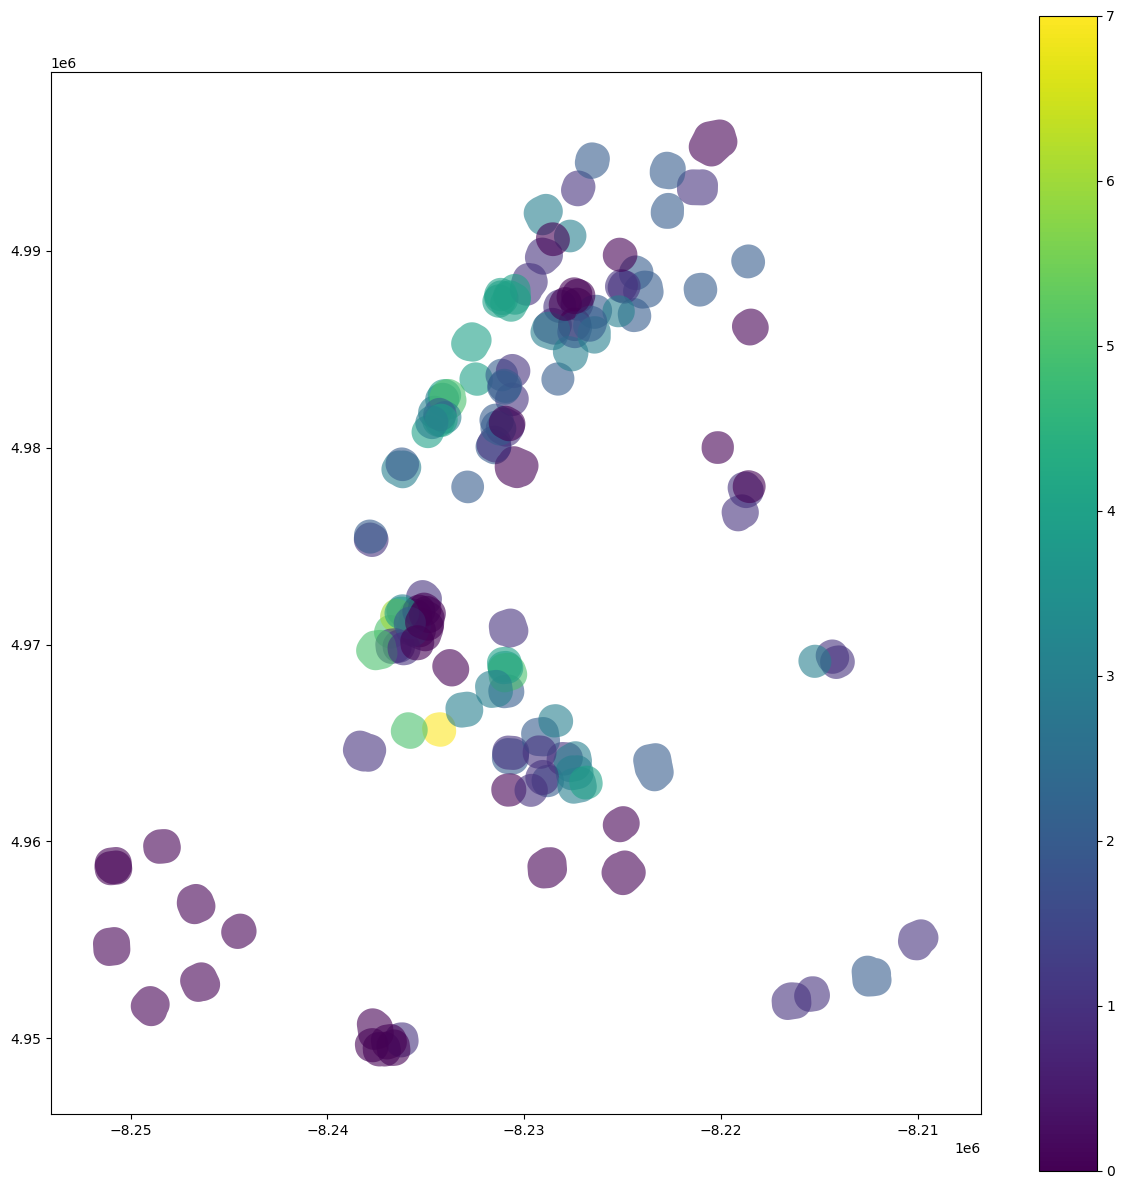

In [40]:
public_housing_buffer.plot(column='station_count',
                            figsize=(15,15),
                            legend=True,
                            alpha=.6)
# Alpha is a value between 0 and 1 that controls the transparency of the fill color

  The default color map (`cmap`) in GeoPandas is `viridis`. You can find other ones [here](https://matplotlib.org/stable/tutorials/colors/colormaps.html). Let's change our color map to `Reds`

<AxesSubplot: >

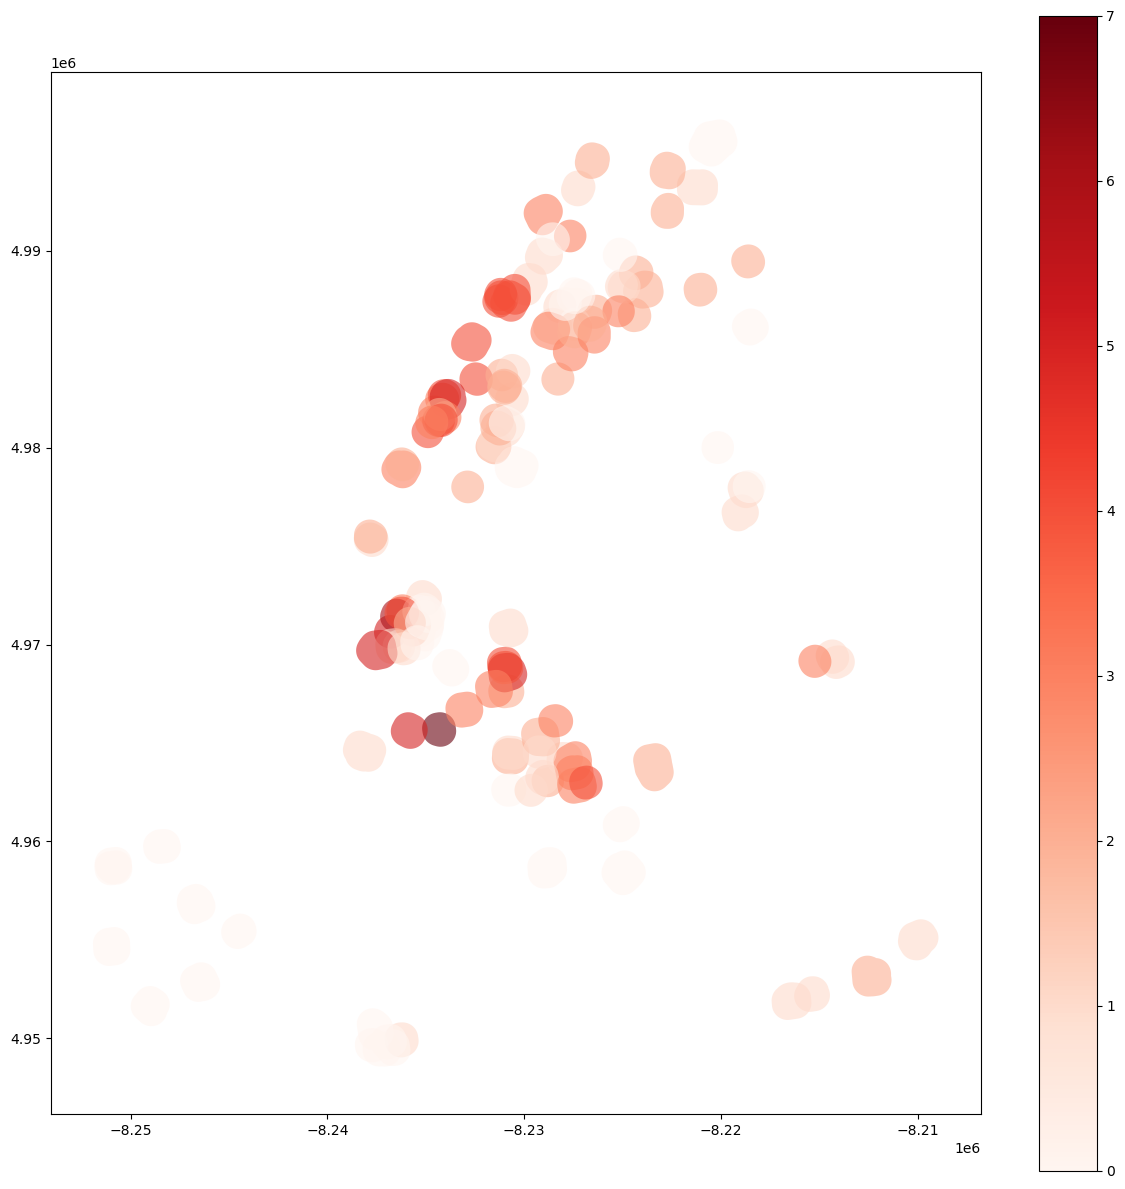

In [41]:
public_housing_buffer.plot(column='station_count',
                            figsize=(15,15),
                            legend=True,
                            alpha=.6,
                            cmap='Reds')

Ok, this is not a great map (and probably won't be today) since it's, without more context, a poetic suggestion of transit accessibility. 

## 4.6 Mapping multiple layers on the same map. 

To give some context to our map, let's plot our subway stations, public housing buildings, and building buffer data together. 

We are going to use a library called `matplotlib` (it's actually being used by `.plot()`). We'll cover this library more extensively in the coming week. 

<AxesSubplot: >

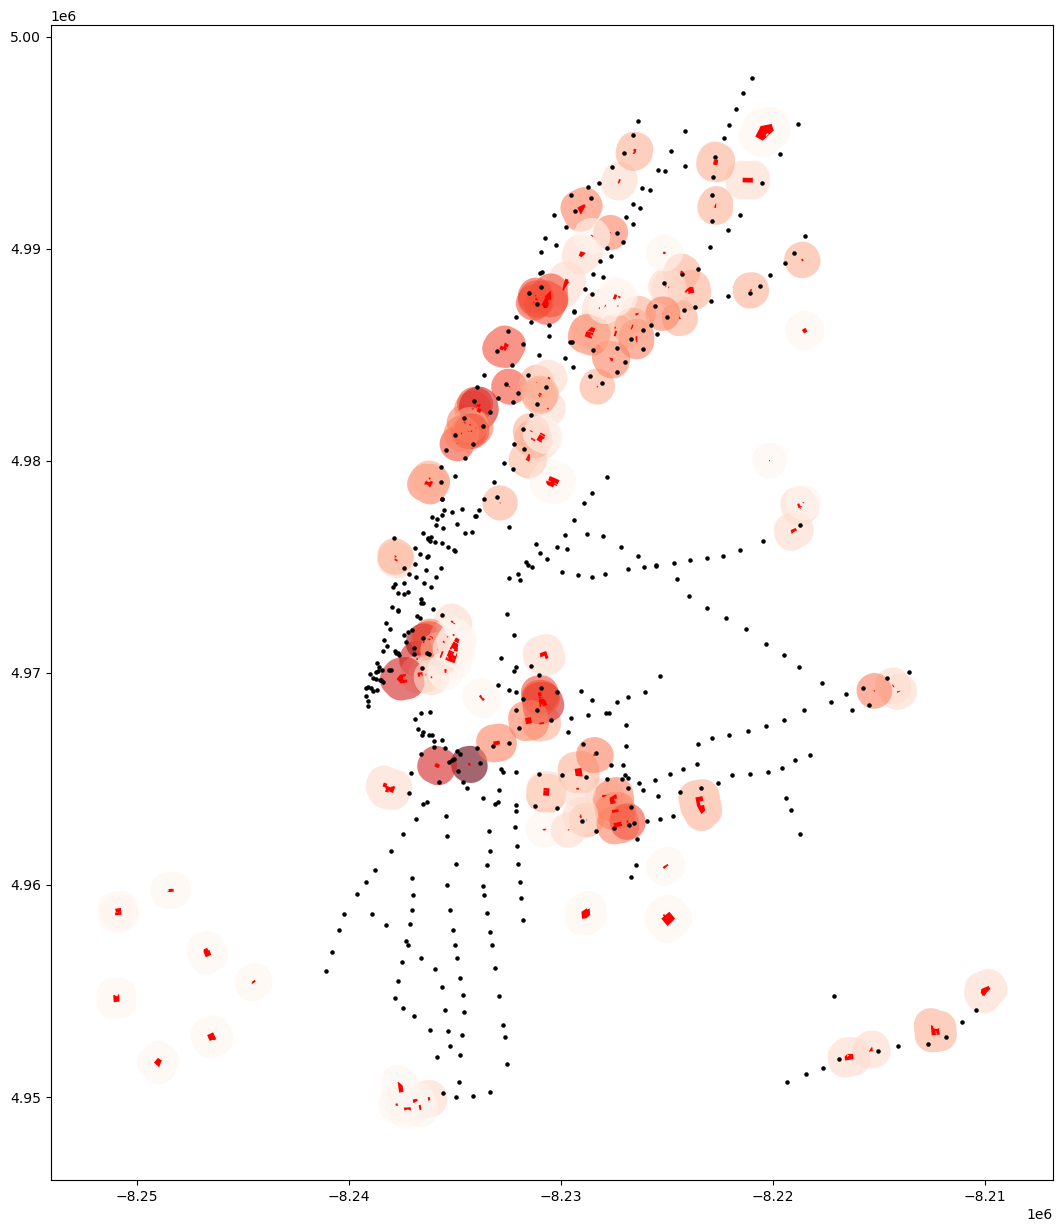

In [42]:
# Import the pyplot module from matplotlib and assign it the nickname plt
import matplotlib.pyplot as plt

# plt.subplots() returns a tuple of the figure and the axis, 
# which we are assigning to fig and ax, respectively

# Note that using this method of creating a plot, 
# we set the figure size using the figsize argument in plt.subplots()
fig1, ax1 = plt.subplots(figsize=(15, 15))

# The drawing order is determined by the order in which we call the plot methods

# We can use the ax argument to specify the axis we want to plot on
# Here, we're plotting the public housing buffer on the axis we just created
public_housing_buffer.plot(column='station_count',
                            ax=ax1,
                            alpha=.6,
                            cmap='Reds')

# markersize is the marker size
stations.plot(markersize=5,
            color='black',
            ax=ax1)
# markersize is the marker size
public_housing.plot(
            color='red',
            ax=ax1)



Still not a great map, but at least we have a bit more context.

## Q.2 In-Class Exercise 2 (2pts)
Which building or buildings have the highest| number of stations within a 10 min walk? Show the code you used to get this answer. 

In [43]:
## Insert your code here
name = public_housing_buffer.sort_values('station_count',ascending=False).iloc[0]['development']
count = public_housing_buffer.sort_values('station_count',ascending=False).iloc[0]['station_count']
print(f'{name} has the highest number of stations within a 10 min walk. The station count is {count}.')

ATLANTIC TERMINAL SITE 4B has the highest number of stations within a 10 min walk. The station count is 7.


## Q.3 In-Class Exercise 3 (5pts)
Create a new column called `area` in `public_housing_buffer` that the area of the original building footprints in meters. (Hint: you'll need to do a `merge`.)

In [44]:
#public_housing

In [45]:
#public_housing_buffer

In [46]:
## Insert your code here

# the base building footprint
public_housing = gpd.read_file('Map of NYCHA Developments.zip')
public_housing = public_housing.to_crs(epsg=3857)
public_housing['area'] = public_housing.area

public_housing_buffer = public_housing_buffer.merge(public_housing[['developmen','area']],
                           left_on='development',
                           right_on='developmen')
public_housing_buffer.head()

,borough,development,tds_num,geometry,station_count,developmen,area
0,BRONX,1010 EAST 178TH STREET,180,"POLYGON ((-8225180.045 4988937.223, -8225178.0...",2,1010 EAST 178TH STREET,14055.643848
1,MANHATTAN,HOLMES TOWERS,159,"POLYGON ((-8231070.035 4980749.205, -8231003.4...",2,HOLMES TOWERS,19377.412336
2,BROOKLYN,104-14 TAPSCOTT STREET,242,"POLYGON ((-8227994.209 4963201.594, -8227983.2...",2,104-14 TAPSCOTT STREET,1644.084771
3,BRONX,1162-1176 WASHINGTON AVENUE,233,"POLYGON ((-8226967.873 4988047.243, -8226897.5...",0,1162-1176 WASHINGTON AVENUE,3100.542315
4,MANHATTAN,131 SAINT NICHOLAS AVENUE,154,"POLYGON ((-8231595.644 4983474.449, -8231595.9...",4,131 SAINT NICHOLAS AVENUE,4906.826076


## Q.4 In-Class Exercise 4 (2 pts)
- From the NYC open data portal, download a [shapefile of neighborhoods](https://data.cityofnewyork.us/City-Government/2010-Neighborhood-Tabulation-Areas-NTAs-/cpf4-rkhq)
- Make sure to change the CRS so it matches the other layers. 
- Add it to the map in section 4.5 *first* (i.e. below the other layers)
- Make the fill color of the neighorhoods `lightgray`.


<AxesSubplot: >

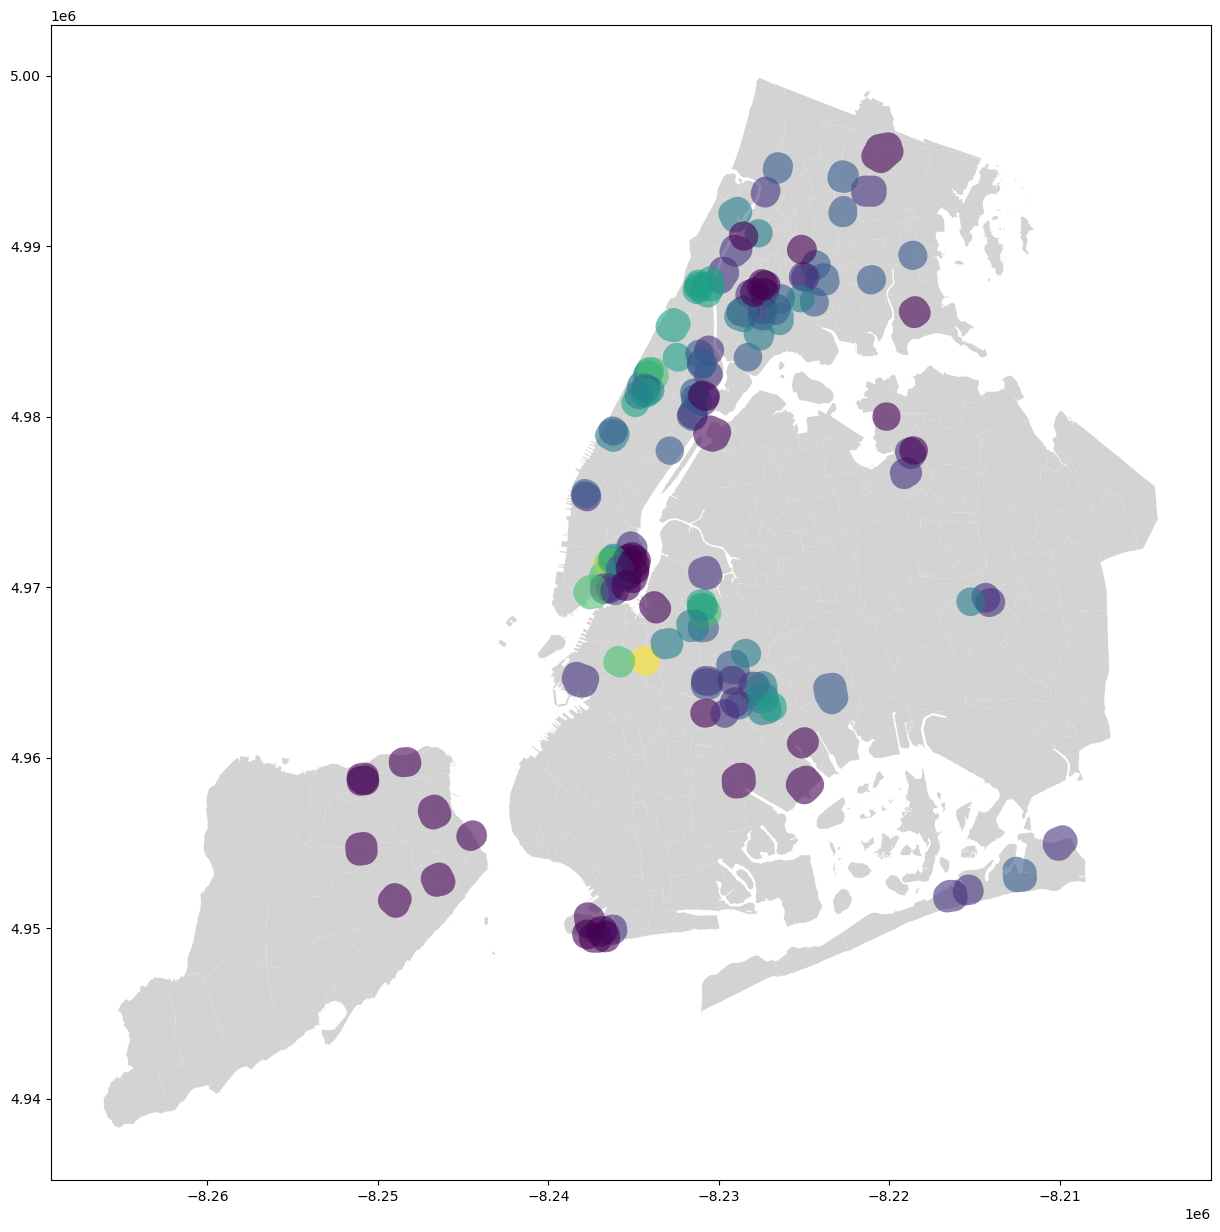

In [47]:
## Insert your code here
neighborhood = gpd.read_file('NTAs.zip')

# change the CRS so it matches the other layers.
neighborhood = neighborhood.to_crs(epsg=3857)

# create a new plot to display

fig2, ax2 = plt.subplots(figsize=(15,15))

neighborhood.plot(color='lightgray',
                     ax=ax2)

public_housing_buffer.plot(column='station_count',
                            ax=ax2,
                            alpha=.6)



## Q.5 In-Class Exercise 5 - OPTIONAL (5pts)
Separately, create a choropleth map that shows the number of subway stations in each neighborhood. 

In [48]:
## Insert your code here

# dataset preperation
neighborhood
# count the number of subway stations within each neighborhood
neigh_count = gpd.sjoin(neighborhood,stations,how='left').groupby('ntacode').count()['objectid']
neighborhood = neighborhood.merge(neigh_count,
                  left_on = 'ntacode',
                  right_index=True)

neighborhood = neighborhood.rename(columns={"objectid":"station_count"})

<AxesSubplot: >

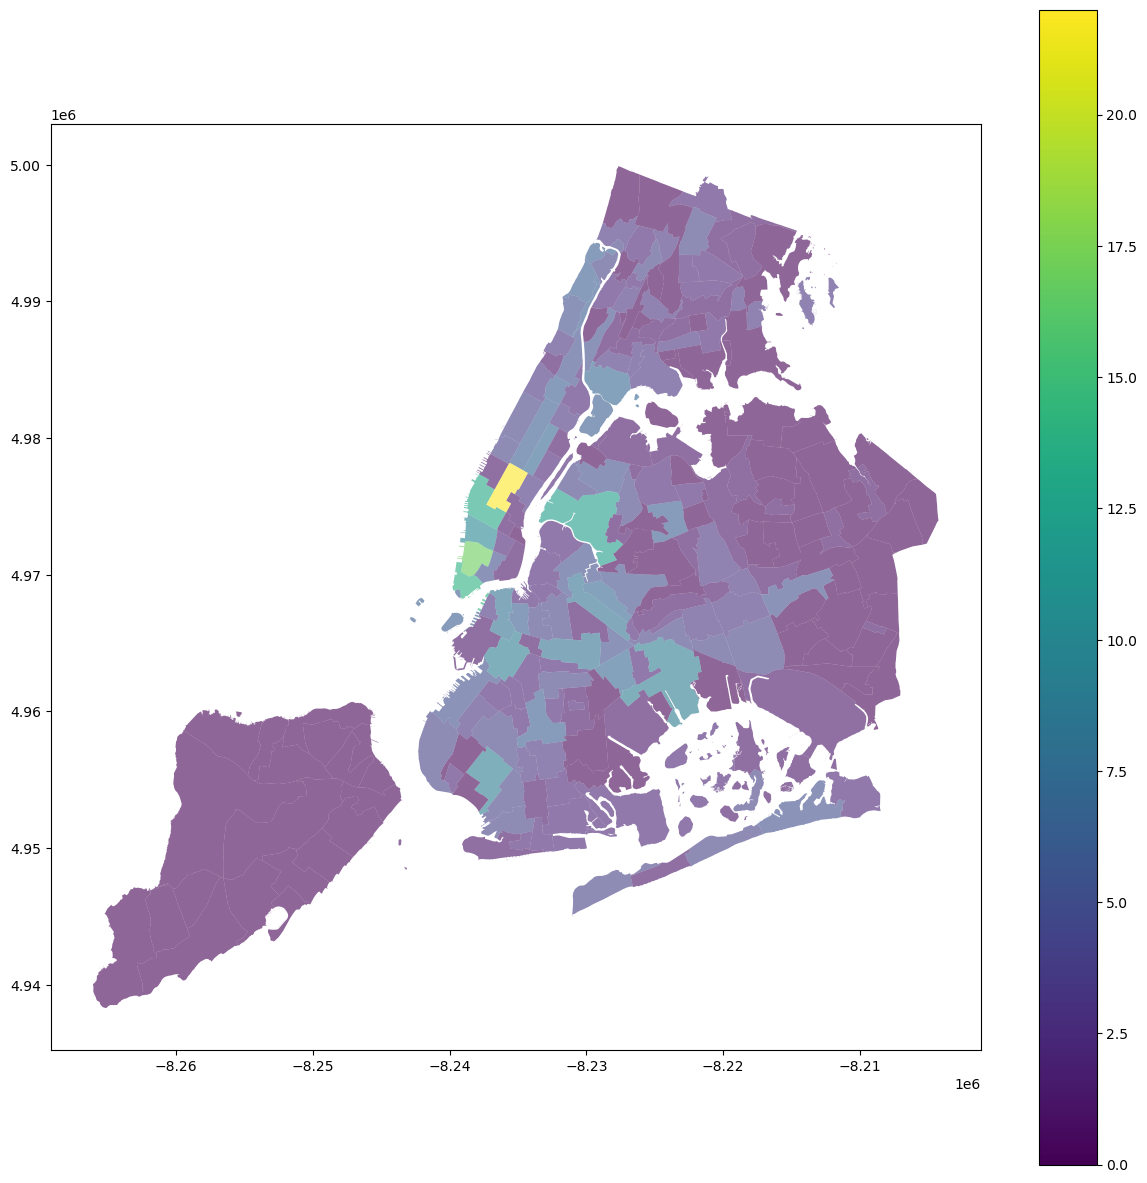

In [49]:
# plot the choropleth map
neighborhood.plot(column='station_count',
                 figsize=(15,15),
                 alpha=0.6,
                  legend=True
                 )